# Querying terrain data for LoRaWAN links in Antwerp

This notebook uses ``proppy.raster`` to query high-dimensional terrain data for each line-segment.

The file uses a dataset of LoRaWAN transmissions in Antwerp, ``antwerp_links.geojson``. These have:
- ``GeoPandas.GeoSeries`` data for each line-segment (in UTM coordinates).
- Elevation data (in m) for the head and tail of each line-segment.

Data is queried from a digital surface model (DSM) raster, in the same coorinate system as the link data.


In [4]:
# import packages
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import xarray as xr
from functools import partial
from multiprocessing import Pool
from time import perf_counter

import matplotlib.pyplot as plt

import proppy.raster as prs

In [10]:
# input data files
linksfile = '../../data/antwerp/antwerp_test.geojson'
rasterfile = "/Volumes/Transcend/lora/data/antwerp-gis/dsm-1m-clipped.tif"  # `proppy_data/antwerp_dsm_1m_tif`

In [11]:
# Load link data
links = gpd.read_file(linksfile)

links = links.rename(columns = {'ele_tx': 'zhead', 'ele_gw':'ztail'})

print(f"Loaded links of shape {links.shape}.")

print("Binary outcomes are:")
print(links['success'].value_counts())

Loaded links of shape (97332, 17).
Binary outcomes are:
False    89352
True      7980
Name: success, dtype: int64


In [77]:
def load_and_process(links, rasterfile, savedir, rel_buffer=0.1,
                     ncols=100, nrows=20, maxsize=None
                     ):
    """Equip links with geodata from raster."""    

    links = links.reset_index(drop=True)
    
    # Verify presence of necessary columns
    linkcols = set(links.columns)

    if 'geometry' not in linkcols:
        raise ValueError("Provided `linksfile` must have a `geometry`-column.")
    
    if 'zhead' not in linkcols:
        raise ValueError("Provided `linksfile` must have  a `zhead`-column.")
    
    if 'ztail' not in linkcols:
        raise ValueError("Provided `linksfile` must have  a `ztail`-column.")

    # Collect relevant columns
    lines = links.geometry[:maxsize]
    zheads, ztails = links["zhead"].values[:maxsize], links["ztail"].values[:maxsize]

    # Compute rectangle features
    rectangles = prs.make_rectangles(lines, zheads, ztails, relative_buffer=rel_buffer)

    # Main "loop" using multiprocessing
    fun_kwargs = {"nrows": nrows, "ncols": ncols, "rasterfile": rasterfile, "savedir": savedir}

    t_start = perf_counter()  # time run

    if maxsize is None:
        maxsize = len(rectangles)

    # use multiprocessing
    with Pool() as p:
        out = p.map(
            partial(prs.save_raster_values, **fun_kwargs), rectangles
        )

    t_stop = perf_counter()
    duration = t_stop - t_start

    return 

In [14]:
# set query dimensions and filenames
ncols, nrows = 150, 20
rel_buffer = 0.05

root = "../../data/antwerp"
datadir = "example"

In [78]:
# Create directory and run query (can take a while)
os.makedirs(os.path.join(root, datadir))

# process the data
load_and_process(
    links, rasterfile, os.path.join(root, datadir), maxsize=None, ncols=ncols, nrows=nrows, rel_buffer=rel_buffer
)

## Visualizing the data

In [43]:
# Select one rectanlge
idx = 0

raster_path = '../../data/antwerp/geodata'

vals = np.genfromtxt(f"{raster_path}/{idx}.csv", delimiter=",")

print(f"Selected Rectanlge {idx}, with data of shape {vals.shape}.")

Selected Rectanlge 0, with data of shape (20, 150).


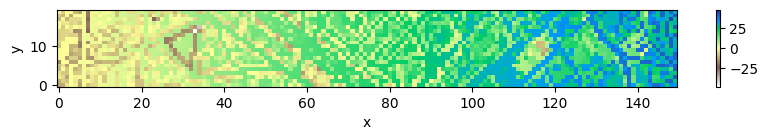

In [44]:
# plot queried data
arr = xr.DataArray(vals.flatten().reshape(nrows, ncols), dims=['y', 'x'])

arr.plot(cmap='terrain_r', figsize=(10, 1));